## Ensemble Hybrid deep learning model for HARon  WISDM Dataset

###   Models

In [1]:
##model_wisdm.py
import numpy as np
import pandas as pd
#import seaborn as sns

In [2]:
#preprocess data 
def preprocess(data):
    #column_names = ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = pd.read_csv(data,on_bad_lines='skip',index_col=False)
    df.columns= ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = df.dropna() # removing null values
    df['z_axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'') # Transforming the z-axis to float
    
    #### Label encoding 
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    df['label'] = label.fit_transform(df['activity'])
    
    ##Balanace this Data :Under sampling
    Walking = df[df['activity']=='Walking'].head(48394).copy()
    Jogging = df[df['activity']=='Jogging'].head(48394).copy()
    Upstairs = df[df['activity']=='Upstairs'].head(48394).copy()
    Downstairs = df[df['activity']=='Downstairs'].head(48394).copy()
    Sitting = df[df['activity']=='Sitting'].head(48394).copy()
    Standing = df[df['activity']=='Standing'].copy()
    
    #df_balanced = pd.DataFrame()
    df_balanced = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
    
    ##Normalize/Standardized data
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    X = df_balanced[['x_axis', 'y_axis', 'z_axis']]
    target = df_balanced['label']
    scaler = StandardScaler()
    dx = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(data = dx, columns = X.columns)
    df_scaled['label'] = target.values
    return df_scaled

In [3]:
dff=preprocess('C:/Datasets/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
#dff.head()

C:\Users\adanent\Anaconda3\envs\Annotation_tool\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
## Segmenting samples (windowing) functions 
import scipy.stats as stats
Fs = 20
segment_size =  500# Fs*4 # window size=n_time steps=frame size
step_size =  25 # Fs*2  # step size 
n_features = 3     

def get_segments(df, segment_size, step_size):
    segments = []
    labels = []
    for i in range(0, len(df) - segment_size - 1, step_size):
        xs = dff['x_axis'].values[i: i + segment_size]
        ys = dff['y_axis'].values[i: i + segment_size]
        zs = dff['z_axis'].values[i: i + segment_size]
        label = stats.mode(dff['label'][i: i + segment_size])[0][0] # [0][0] shows the index of the current sequence
        #We used the dstack() to ensure that each array is stacked in such a way that
        #the features are separated in the third dimension, as we would prefer.
        segments.append(np.dstack([xs, ys, zs]))
        labels.append(label)

    # Bring the segments into a better shape
    segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
                
    return segments, labels

In [5]:
X, y = get_segments(dff, segment_size, step_size)

In [6]:
X.shape,y.shape

((11595, 500, 3), (11595, 6))

### CNN-LSTM
The CNN-LSTM architecture involves using Convolutional Neural Network (CNN) layers for
feature extraction on input data combined with LSTMs to support sequence prediction. The CNN-LSTM model will read subsequences of the main sequence in as blocks, extract features from each block, then allow the LSTM to interpret the features extracted from each block. One approach to implementing this model is to split each window of 128 time steps into
subsequences for the CNN model to process. For example, the 128 time steps in each window can be split into four subsequences of 32 time steps

In [7]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 10, 50
df_X = X.reshape((X.shape[0], n_steps, n_length, n_features))
n_outputs = y.shape[1]#n_outputs= 6

In [8]:
df_X.shape,np.shape(y)

((11595, 10, 50, 3), (11595, 6))

We can then define a CNN model that expects to read in sequences with a length of 32 time
steps and three features. The entire CNN model can be wrapped in a TimeDistributed layer
to allow the same CNN model to read in each of the four subsequences in the window. The
extracted features are then flattened and provided to the LSTM model to read, extracting its
own features before a final mapping to an activity is made.

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [10]:
#from sklearn.model_selection import GridSearchCV
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

In [11]:
# split training set into training and validation set
#X_train, X_test, y_train, y_test = train_test_split(df_X,y,test_size=0.20,random_state=7)

In [12]:
# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(df_X, y,test_size=0.20, random_state=7)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.30,random_state=7)

In [13]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((6493, 10, 50, 3), (2319, 10, 50, 3), (6493, 6), (2319, 6))

In [14]:
def create_model(optimizer= 'rmsprop' , init= 'glorot_uniform' ):
    # create model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
### Initialize Model
model_cnn_lstm=create_model()

## Save Model

In [16]:
history = model_cnn_lstm.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=50)

Epoch 1/10
130/130 [==============================] - 41s 204ms/step - loss: 0.6176 - accuracy: 0.7496 - val_loss: 0.2462 - val_accuracy: 0.8908
Epoch 2/10
130/130 [==============================] - 22s 172ms/step - loss: 0.1721 - accuracy: 0.9313 - val_loss: 0.0769 - val_accuracy: 0.9713
Epoch 3/10
130/130 [==============================] - 23s 175ms/step - loss: 0.0786 - accuracy: 0.9737 - val_loss: 0.0330 - val_accuracy: 0.9885
Epoch 4/10
130/130 [==============================] - 17s 129ms/step - loss: 0.0332 - accuracy: 0.9892 - val_loss: 0.0266 - val_accuracy: 0.9914
Epoch 5/10
130/130 [==============================] - 16s 123ms/step - loss: 0.0410 - accuracy: 0.9877 - val_loss: 0.0344 - val_accuracy: 0.9889
Epoch 6/10
130/130 [==============================] - 16s 124ms/step - loss: 0.0268 - accuracy: 0.9909 - val_loss: 0.0155 - val_accuracy: 0.9953
Epoch 7/10
130/130 [==============================] - 24s 181ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.0103 - val_ac

In [17]:
model_cnn_lstm.save('cnn_lstm_500.h5')

In [18]:
np.set_printoptions(suppress=True) #suppress scientific notation when printing :numpy 

In [19]:
# Make Predictions on test 
y_preds_test = model_cnn_lstm.predict(X_test) #class Prediction 

y_preds_test[:3], #y_probs_test[:5]

73/73 [==============================] - 12s 56ms/step


(array([[0.00000208, 0.00000011, 0.99999344, 0.00000292, 0.00000147,
         0.00000012],
        [0.00000451, 0.00000024, 0.00021169, 0.99977905, 0.00000109,
         0.00000345],
        [0.00026274, 0.00000034, 0.00000768, 0.00000335, 0.99972445,
         0.00000145]], dtype=float32),)

In [20]:
y_test[:5,]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [21]:
y_pred_test=np.argmax(y_preds_test,axis=1) 
y_true_test=np.argmax(y_test,axis=1) 

y_true_test.shape, y_pred_test.shape

((2319,), (2319,))

###  Evaluate Model

In [22]:
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true_test,y_pred_test)
print(cm)
print(acc(y_true_test,y_pred_test))
print(classification_report(y_true_test,y_pred_test))

[[390   0   1   0   1   0]
 [  0 403   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 374   0   0]
 [  0   0   0   0 414   0]
 [  1   1   0   0   0 378]]
0.9982751185855973
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       392
           1       1.00      1.00      1.00       403
           2       1.00      1.00      1.00       356
           3       1.00      1.00      1.00       374
           4       1.00      1.00      1.00       414
           5       1.00      0.99      1.00       380

    accuracy                           1.00      2319
   macro avg       1.00      1.00      1.00      2319
weighted avg       1.00      1.00      1.00      2319



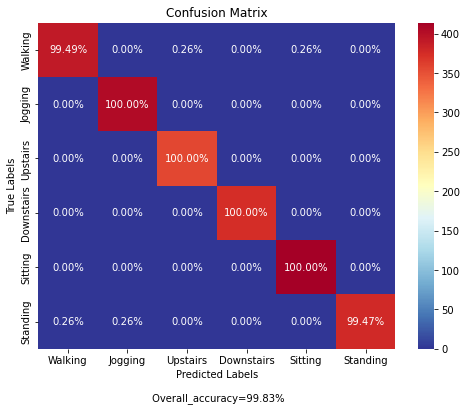

In [23]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))
    
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(y_true_test,y_pred_test)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
ax.yaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
plt.savefig('ConfusionMatrix_Ensem-HAR_WISDM',dpi=1200, bbox_inches='tight')

In [24]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')

(0.9982927414526364, 0.9982724668814895, 0.9982803509022101, None)